# Implementing the ViT paper from scratch
* In this notebook I am going to implement the ViT paper form scratch in pytorch

In [1]:
# importing torch and torchvision and other libraries

import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

2.3.1+cu118
0.18.1+cu118


In [2]:
# continuting with regular imports

import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms


try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary


try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [3]:
# Setting up our device

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Getting the data ready

In [4]:
# getting the data 

# Downloading pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [5]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

In [6]:
# the original image size in the ViT paper is 224
IMG_SIZE = 224

# creating a manual transform
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor()
])

print(manual_transforms)

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [7]:
#setting the batch size
BATCH_SIZE = 16 # THE ORIGINAL BATCH SIZE IN VIT PAPER IS 4096, HERE DUE TO COMPUTATIONAL LIMITATIONS WE ARE USING 32

# creating the data loader
train_dataloader,test_dataloader,class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                             test_dir = test_dir,
                                                                             transform = manual_transforms,
                                                                             batch_size = BATCH_SIZE,
                                                                            )

train_dataloader,test_dataloader,class_names

(<torch.utils.data.dataloader.DataLoader at 0x7cb1c31d7990>,
 ['pizza', 'steak', 'sushi'])

In [8]:
# geting a batch of images
image_batch,label_batch = next(iter(train_dataloader))

# getting an image from batch
image,label = image_batch[0],label_batch[0]

image.shape,label

(torch.Size([3, 224, 224]), tensor(1))

Text(0.5, 1.0, 'steak')

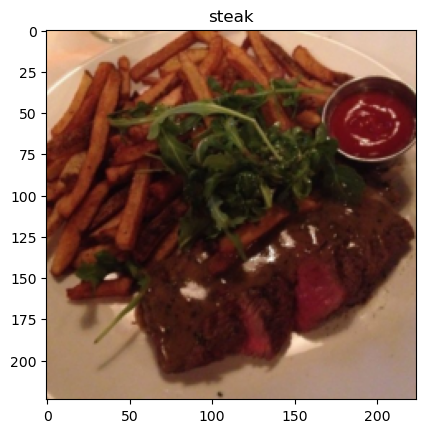

In [9]:
# checking the image

img = image.permute(1,2,0)
plt.imshow(img)
plt.title(class_names[label])

## Splitting data into patches and creating the class, position and patch embeddings

In [10]:
height = 224
width = 224
color_channels = 3
patch_size = 16

no_of_patches = (height*width)/patch_size**2
no_of_patches

196.0

In [11]:
# input_shape 
embedding_layer_input_shape = (height,width,color_channels)

# output_shape
embedding_layer_output_shape = (no_of_patches,patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196.0, 768)


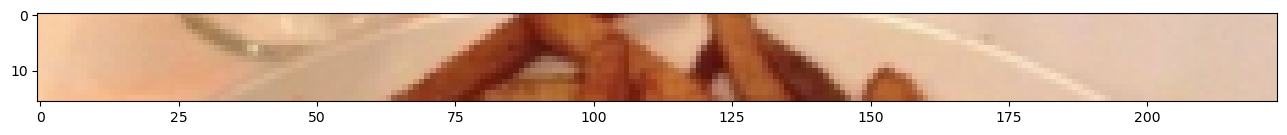

In [12]:
# Change image shape to be compatible with matplotlib (color_channels, height, width) -> (height, width, color_channels)
image_permuted = image.permute(1, 2, 0)

# Index to plot the top row of patched pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :]);

In [13]:
# # Setup hyperparameters and make sure img_size and patch_size are compatible
# img_size = 224
# patch_size = 16
# num_patches = img_size/patch_size
# assert img_size % patch_size == 0, "Image size must be divisible by patch size"
# print(f"Number of patches per row: {num_patches}\
#         \nNumber of patches per column: {num_patches}\
#         \nTotal patches: {num_patches*num_patches}\
#         \nPatch size: {patch_size} pixels x {patch_size} pixels")

# # Create a series of subplots
# fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
#                         ncols=img_size // patch_size,
#                         figsize=(num_patches, num_patches),
#                         sharex=True,
#                         sharey=True)

# # Loop through height and width of image
# for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
#     for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width

#         # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
#         axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
#                                         patch_width:patch_width+patch_size, # iterate through width
#                                         :]) # get all color channels

#         # Set up label information, remove the ticks for clarity and set labels to outside
#         axs[i, j].set_ylabel(i+1,
#                              rotation="horizontal",
#                              horizontalalignment="right",
#                              verticalalignment="center")
#         axs[i, j].set_xlabel(j+1)
#         axs[i, j].set_xticks([])
#         axs[i, j].set_yticks([])
#         axs[i, j].label_outer()

# # Set a super title
# fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
# plt.show()

In [14]:
# creating image patches using conv2d
patch_size = 16

conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768,
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)

image_out_of_conv = conv2d(image.unsqueeze(0))
print(image.shape)
print(image_out_of_conv.shape)

torch.Size([3, 224, 224])
torch.Size([1, 768, 14, 14])


Showing random convolutional feature maps from indexes: [424, 561, 459, 698, 79]


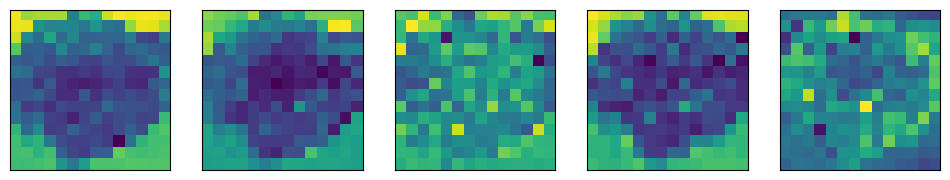

In [15]:
# Plot random 5 convolutional feature maps
import random
random_indexes = random.sample(range(0, 758), k=5) # pick 5 numbers between 0 and the embedding size
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

In [16]:
# Flattening the patch embedding

flatten = nn.Flatten(start_dim=2,
                     end_dim=3)

In [17]:
#putting it all together

image_out_of_conv = conv2d(image.unsqueeze(0))
image_out_of_conv_flattened = flatten(image_out_of_conv)

print(image.shape)
print(image_out_of_conv.shape)
print(image_out_of_conv_flattened.shape)

torch.Size([3, 224, 224])
torch.Size([1, 768, 14, 14])
torch.Size([1, 768, 196])


In [18]:
# transforming flattened output to desired shape

image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0,2,1)
image_out_of_conv_flattened_reshaped.shape

torch.Size([1, 196, 768])

In [19]:
# turning the patch embedding into Pytorch module

class PatchEmbedding(nn.Module):
    
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768,
                ):
        super().__init__()

        self.patcher = nn.Conv2d(in_channels = in_channels,
                                 out_channels = embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0,
                                )

        self.flatten = nn.Flatten(start_dim=2,
                                  end_dim=3)
        

    def forward(self,x):
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"

        x_patcher = self.patcher(x)
        x_flattened = self.flatten(x_patcher)

        return x_flattened.permute(0,2,1)
        
                 

In [20]:
PatchEmbedding

__main__.PatchEmbedding

In [21]:
set_seeds()

# Creating an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Passing a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [22]:
# Create random input sizes
random_input_image = (1, 3, 224, 224)
random_input_image_error = (1, 3, 250, 250) # will error because image size is incompatible with patch_size

# Get a summary of the input and outputs of PatchEmbedding (uncomment for full output)
summary(PatchEmbedding(),
        input_size=random_input_image, # try swapping this for "random_input_image_error"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

/home/srujan/anaconda3/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:84.)
  return F.conv2d(input, weight, bias, self.stride,


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

In [23]:
# creating the class token embedding

batch_size = patch_embedded_image.shape[0]
embedding_size = patch_embedded_image.shape[-1]

class_token = nn.Parameter(torch.ones(batch_size,1,embedding_size),requires_grad = True)

# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1) # concat on first dimension

patch_embedded_image_with_class_embedding.shape

torch.Size([1, 197, 768])

In [24]:
# creating positional embedding


number_of_patches = int((height * width) / patch_size**2)



position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_size),
                                  requires_grad=True)

position_embedding.shape

torch.Size([1, 197, 768])

### Putting it all together from image to embedding

In [25]:
set_seeds()

# 1. Set patch size
patch_size = 16

# 2. Print shape of original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


## Multihead attention (MSA)

In [26]:
class MultiheadSelfAttentionBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 num_heads:int=12,
                 attn_dropout:float=0):
        super().__init__()

        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True)

    def forward(self,x):
        x = self.layer_norm(x)
        attn_output,_ = self.multihead_attn(query=x,
                                            key=x,
                                            value=x,
                                            need_weights=False)
        return attn_output
        

In [27]:
# Create an instance of MSABlock
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768, # from Table 1
                                                             num_heads=12) # from Table 1

# Pass patch and position image embedding through MSABlock
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


## MLP layers

In [28]:
class MLPBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 mlp_size:int=3072,
                 dropout:float=0.1):
        super().__init__()

        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        self.mlp = nn.Sequential(
            nn.Linear(in_features = embedding_dim,
                      out_features = mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features = mlp_size,
                      out_features = embedding_dim),
            nn.Dropout(p=dropout)
        )

    def forward(self,x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x
                      

In [29]:
mlp_block = MLPBlock(embedding_dim=768,
                     mlp_size=3072,
                     dropout=0.1)

patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(patched_image_through_msa_block.shape)
print(patched_image_through_mlp_block.shape)

torch.Size([1, 197, 768])
torch.Size([1, 197, 768])


In [30]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self,
                  embedding_dim:int=768,
                  mlp_size:int=3072,
                  num_heads:int=12,
                  msa_dropout:float=0,
                  mlp_dropout:float=0.1):
        super().__init__()

        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=msa_dropout)

        self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                                  mlp_size=mlp_size,
                                  dropout=mlp_dropout)


    def forward(self,x):

        x = self.msa_block(x) + x
        x = self.mlp_block(x) + x
        return x
                  


In [31]:
# Create an instance of TransformerEncoderBlock
transformer_encoder_block = TransformerEncoderBlock()

# Print an input and output summary of our Transformer Encoder (uncomment for full output)
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

## Putting it all together to create ViT

In [32]:
class ViT(nn.Module):
    def __init__(self,
                 img_size:int=224,
                 patch_size:int=16,
                 in_channels:int=3,
                 num_transformer_layers:int=12,
                 embedding_dim:int=768,
                 mlp_size:int=3072,
                 num_heads:int=12,
                 attn_dropout:float=0,
                 mlp_dropout:float=0.1,
                 embedding_dropout:float=0.1,
                 num_classes:int=1000):
                 
        super().__init__()

        assert img_size % patch_size == 0, "image size must be divisible by patch_size"

        self.num_patches = (img_size * img_size) // patch_size**2

        self.class_embedding = nn.Parameter(data=torch.randn(1,1,embedding_dim),
                                            requires_grad=True)
        
        self.position_embedding = nn.Parameter(data=torch.randn(1,self.num_patches+1,embedding_dim),
                                               requires_grad=True)

        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )


    def forward(self,x):
        
        batch_size = x.shape[0]

        class_token = self.class_embedding.expand(batch_size,-1,-1)

        x = self.patch_embedding(x)

        x = torch.cat((class_token,x),dim=1)

        x = self.position_embedding + x

        x = self.embedding_dropout(x)

        x = self.transformer_encoder(x)

        x = self.classifier(x[:,0])

        return x
        

In [33]:
# Example of creating the class embedding and expanding over a batch dimension
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768)) # create a single learnable class token
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1) # expand the single learnable class token across the batch dimension, "-1" means to "infer the dimension"

# Print out the change in shapes
print(f"Shape of class token embedding single: {class_token_embedding_single.shape}")
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([32, 1, 768])


In [34]:
set_seeds()

# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor).shape

torch.Size([1, 3])

In [35]:
from torchinfo import summary

# Print a summary of our custom ViT model using torchinfo (uncomment for actual output)
summary(model=vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]       [32, 197, 768]

## Training our ViT model

In [36]:
from going_modular.going_modular import engine

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params = vit.parameters(),
                             lr = 3e-3,
                             betas=(0.9,0.999),
                             weight_decay=0.3)

set_seeds()

results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer = optimizer,
                       loss_fn = loss_fn,
                       epochs=10,
                       device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.5562 | train_acc: 0.3208 | test_loss: 2.4985 | test_acc: 0.3125
Epoch: 2 | train_loss: 1.3063 | train_acc: 0.3167 | test_loss: 1.3675 | test_acc: 0.3125
Epoch: 3 | train_loss: 1.1662 | train_acc: 0.3208 | test_loss: 1.1741 | test_acc: 0.3125
Epoch: 4 | train_loss: 1.1870 | train_acc: 0.2917 | test_loss: 1.2524 | test_acc: 0.2375
Epoch: 5 | train_loss: 1.1795 | train_acc: 0.3333 | test_loss: 1.1395 | test_acc: 0.3125
Epoch: 6 | train_loss: 1.1861 | train_acc: 0.3292 | test_loss: 1.1663 | test_acc: 0.2375
Epoch: 7 | train_loss: 1.2534 | train_acc: 0.2750 | test_loss: 1.1733 | test_acc: 0.2375
Epoch: 8 | train_loss: 1.1893 | train_acc: 0.3958 | test_loss: 1.2202 | test_acc: 0.3125
Epoch: 9 | train_loss: 1.1743 | train_acc: 0.3708 | test_loss: 1.0934 | test_acc: 0.4500
Epoch: 10 | train_loss: 1.2553 | train_acc: 0.3000 | test_loss: 1.2734 | test_acc: 0.2375


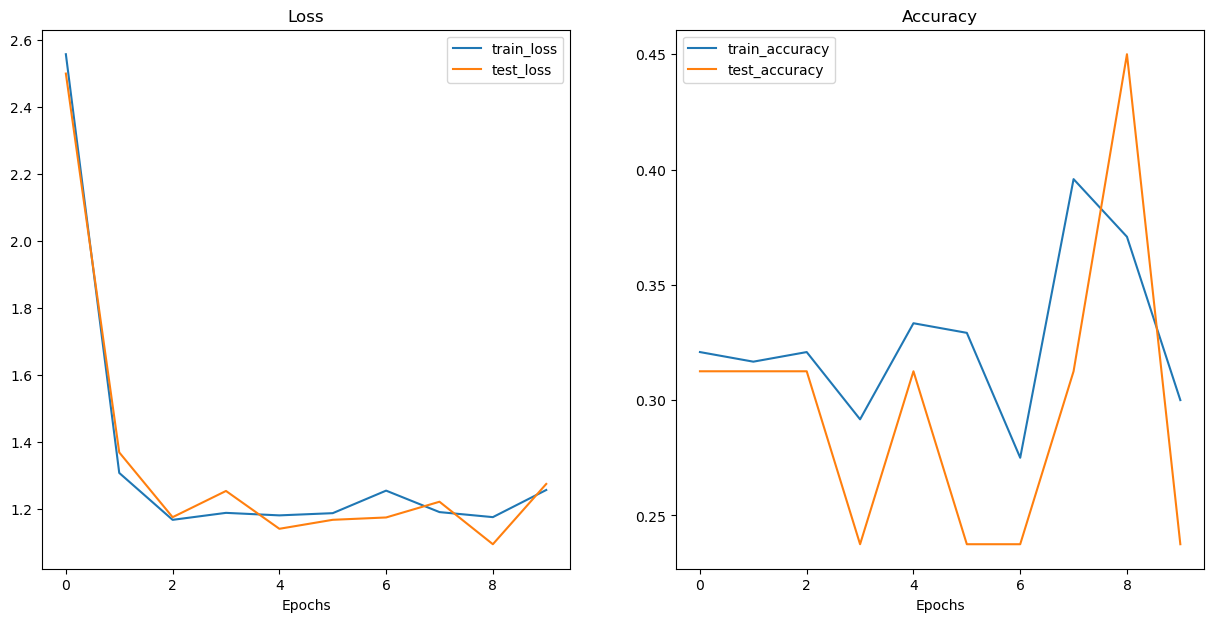

In [37]:
from helper_functions import plot_loss_curves

# Plot our ViT model's loss curves
plot_loss_curves(results)